In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-03"
end_date = "2022-02-04"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-03.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-04.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

In [4]:
df.head()

,Open,High,Low,Close,Volume
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702


In [5]:
df.tail()

,Open,High,Low,Close,Volume
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872
2022-02-04 23:59:59,41554.57,41574.25,41554.57,41574.25,5.70223


## Adding TAs

#### Volatility Indicators

In [6]:
# #bbs: EITHER 0 or 1. Very bad
# # Add bollinger band high indicator filling nans values
# df["bb_high_indicator"] = ta.volatility.bollinger_hband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )
# # Add bollinger band low indicator filling nans values
# df["bb_low_indicator"] = ta.volatility.bollinger_lband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )

In [7]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [8]:
window = 30 # a choice
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# Relative Strength Index (RSI)
df["momentum_rsi"] = RSIIndicator(
    close=df["Close"], window=14, fillna=True
).rsi()/100 #scale 0-1

# Stoch RSI (StochRSI)
indicator_srsi = StochRSIIndicator(
    close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
)
df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

In [9]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555


In [10]:
df.tail()

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237,0.006162,0.379324,0.000000,0.305972,0.609338,0.148126
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854,0.014034,0.440097,0.225454,0.075151,0.333331,0.101344
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596,0.021114,0.400449,0.078369,0.101274,0.160799,0.048798
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872,0.033150,0.492519,0.429676,0.244500,0.140309,0.036460
2022-02-04 23:59:59,41554.57,41574.25,41554.57,41574.25,5.70223,0.052319,0.684532,1.000000,0.502682,0.282819,0.117373


#### Volume indicators
- Money Flow Index (MFI)
- Chaikin Money Flow (CMF)
- Force Index (FI)
- Volume Weighted Average Price (VWAP)
- ~Accumulation/Distribution Index (ADI)~
- ~On-Balance Volume (OBV)~
- ~Ease of Movement (EoM, EMV)~
- ~Volume-price Trend (VPT)~
- ~Negative Volume Index (NVI)~

In [11]:
# Chaikin Money Flow
df["volume_cmf"] = ChaikinMoneyFlowIndicator(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
).chaikin_money_flow()

# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).money_flow_index()/100 #norm to 0-1

# Force Index
df["volume_fi"] = ForceIndexIndicator(
    close=df["Close"], volume=df["Volume"], window=13, fillna=True
).force_index()

# Volume Weighted Average Price
df["volume_vwap"] = VolumeWeightedAveragePrice(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
    window=14,
).volume_weighted_average_price()

In [12]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,0.000000,36902.313333
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,-0.008738,36902.319379
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,-0.381027,36901.906596
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,-0.248998,36901.715442
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,-0.443275,36901.498579
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366,0.046164,0.502091,0.551702,36901.455574
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129,-0.084847,0.358914,0.215362,36901.257014
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333,-0.027345,0.318344,0.184596,36900.997098
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051,-0.020690,0.327692,0.158225,36900.982261
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555,-0.038228,0.315419,0.067200,36900.909429


#### Trend indicators
- Simple Moving Average (SMA) (slow only)
- Exponential Moving Average (EMA) (slow only)
- Moving Average Convergence Divergence (MACD, signal, diff)

In [13]:
# MACD
indicator_macd = MACD(
    close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
)
df["trend_macd"] = indicator_macd.macd()
df["trend_macd_signal"] = indicator_macd.macd_signal()
df["trend_macd_diff"] = indicator_macd.macd_diff()

# SMAs
# df["trend_sma_fast"] = SMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).sma_indicator()
df["trend_sma_slow"] = SMAIndicator(
    close=df["Close"], window=26, fillna=True
).sma_indicator()

# EMAs
# df["trend_ema_fast"] = EMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).ema_indicator()
df["trend_ema_slow"] = EMAIndicator(
    close=df["Close"], window=26, fillna=True
).ema_indicator()

In [14]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,0.000000,36902.313333,0.000000,0.000000,0.000000,36902.960000,36902.960000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,-0.008738,36902.319379,-0.011966,-0.002393,-0.009573,36902.885000,36902.948889
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,-0.381027,36901.906596,-0.309979,-0.063910,-0.246069,36901.653333,36902.670453
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,-0.248998,36901.715442,-0.432241,-0.137576,-0.294664,36901.375000,36902.512641
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,-0.443275,36901.498579,-0.915583,-0.293178,-0.622405,36900.224000,36902.002075
2022-02-03 00:00:05,36898.68,36904.81,36898.68,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366,0.046164,0.502091,0.551702,36901.455574,-0.913693,-0.417281,-0.496412,36900.230000,36901.873033
2022-02-03 00:00:06,36899.42,36902.19,36898.71,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129,-0.084847,0.358914,0.215362,36901.257014,-1.025446,-0.538914,-0.486532,36900.012857,36901.638734
2022-02-03 00:00:07,36898.71,36898.71,36891.64,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333,-0.027345,0.318344,0.184596,36900.997098,-1.101317,-0.651394,-0.449922,36899.850000,36901.421791
2022-02-03 00:00:08,36898.70,36898.71,36898.70,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051,-0.020690,0.327692,0.158225,36900.982261,-1.148208,-0.750757,-0.397451,36899.723333,36901.220917
2022-02-03 00:00:09,36898.71,36898.71,36896.06,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555,-0.038228,0.315419,0.067200,36900.909429,-1.382460,-0.877098,-0.505363,36899.358000,36900.839368


### use gen_feats0

In [15]:
df = gen_feats0(df)
df

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,...,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,...,36902.313333,0.000000,0.000000,0.000000,36902.960000,36902.960000,11.26,4.66,0.01,6.59
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,...,36902.319379,-0.011966,-0.002393,-0.009573,36902.885000,36902.948889,0.17,0.00,0.01,-0.16
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,...,36901.906596,-0.309979,-0.063910,-0.246069,36901.653333,36902.670453,4.72,0.01,2.80,-1.91
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,...,36901.715442,-0.432241,-0.137576,-0.294664,36901.375000,36902.512641,5.01,0.00,3.66,1.35
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,...,36901.498579,-0.915583,-0.293178,-0.622405,36900.224000,36902.002075,4.92,0.01,0.00,-4.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04 23:59:55,41556.61,41564.16,41545.77,41545.77,2.19237,0.006162,0.379324,0.000000,0.305972,0.609338,...,41556.708463,2.177282,3.290843,-1.113560,41554.110000,41553.597403,18.39,7.55,0.00,-10.84
2022-02-04 23:59:56,41544.21,41553.85,41544.20,41549.21,1.27854,0.014034,0.440097,0.225454,0.075151,0.333331,...,41555.700995,1.492324,2.931139,-1.438815,41554.130385,41553.272410,9.65,4.64,0.01,5.00
2022-02-04 23:59:57,41546.06,41547.44,41541.41,41545.98,2.26596,0.021114,0.400449,0.078369,0.101274,0.160799,...,41552.822238,0.681005,2.481112,-1.800107,41553.765385,41552.732232,6.03,1.38,4.57,-0.08
2022-02-04 23:59:58,41545.98,41552.03,41545.98,41552.02,0.22872,0.033150,0.492519,0.429676,0.244500,0.140309,...,41551.723361,0.519418,2.088773,-1.569355,41553.633077,41552.679474,6.05,0.01,0.00,6.04


## Drop OHL, stationize C, and related

In [16]:
def stationize(series):
    return np.log(series / series.shift(1))

In [17]:
df.head()

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,...,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,NaN,1.000000,0.0,0.0,0.0,...,36902.313333,0.000000,0.000000,0.000000,36902.960000,36902.960000,11.26,4.66,0.01,6.59
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,NaN,0.000000,0.0,0.0,0.0,...,36902.319379,-0.011966,-0.002393,-0.009573,36902.885000,36902.948889,0.17,0.00,0.01,-0.16
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,NaN,0.000000,0.0,0.0,0.0,...,36901.906596,-0.309979,-0.063910,-0.246069,36901.653333,36902.670453,4.72,0.01,2.80,-1.91
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,NaN,0.278882,0.0,0.0,0.0,...,36901.715442,-0.432241,-0.137576,-0.294664,36901.375000,36902.512641,5.01,0.00,3.66,1.35
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,NaN,0.133146,0.0,0.0,0.0,...,36901.498579,-0.915583,-0.293178,-0.622405,36900.224000,36902.002075,4.92,0.01,0.00,-4.91


In [18]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
# the initial price is at 00:00:00
df['log_ret'] = stationize(df['Close'])
df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [19]:
df.drop(["Open","High","Low"], axis=1, inplace=True)

In [20]:
df

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade,log_ret,log_volume_vwap_ret,log_trend_sma_slow_ret,log_trend_ema_slow_ret
2022-02-03 00:00:00,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,...,36902.960000,36902.960000,11.26,4.66,0.01,6.59,NaN,NaN,NaN,NaN
2022-02-03 00:00:01,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,...,36902.885000,36902.948889,0.17,0.00,0.01,-0.16,-0.000004,1.638353e-07,-2.032359e-06,-3.010900e-07
2022-02-03 00:00:02,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,...,36901.653333,36902.670453,4.72,0.01,2.80,-1.91,-0.000098,-1.118590e-05,-3.337645e-05,-7.545122e-06
2022-02-03 00:00:03,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,...,36901.375000,36902.512641,5.01,0.00,3.66,1.35,0.000037,-5.180055e-06,-7.542599e-06,-4.276429e-06
2022-02-03 00:00:04,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,...,36900.224000,36902.002075,4.92,0.01,0.00,-4.91,-0.000133,-5.876793e-06,-3.119174e-05,-1.383563e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04 23:59:55,41545.77,2.19237,0.006162,0.379324,0.000000,0.305972,0.609338,0.148126,-0.343437,0.505122,...,41554.110000,41553.597403,18.39,7.55,0.00,-10.84,-0.000261,-4.255103e-05,-6.238371e-06,-1.506939e-05
2022-02-04 23:59:56,41549.21,1.27854,0.014034,0.440097,0.225454,0.075151,0.333331,0.101344,-0.260247,0.435398,...,41554.130385,41553.272410,9.65,4.64,0.01,5.00,0.000083,-2.424349e-05,4.905558e-07,-7.821082e-06
2022-02-04 23:59:57,41545.98,2.26596,0.021114,0.400449,0.078369,0.101274,0.160799,0.048798,-0.112530,0.227198,...,41553.765385,41552.732232,6.03,1.38,4.57,-0.08,-0.000078,-6.927706e-05,-8.783762e-06,-1.299975e-05
2022-02-04 23:59:58,41552.02,0.22872,0.033150,0.492519,0.429676,0.244500,0.140309,0.036460,-0.087622,0.122125,...,41553.633077,41552.679474,6.05,0.01,0.00,6.04,0.000145,-2.644566e-05,-3.184017e-06,-1.269662e-06


In [21]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [22]:
HORIZON = 1
WINDOW = 30

In [23]:
# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  df[f"log_ret+{i+1}"] = df["log_ret"].shift(periods=i+1)
df.head(50)

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:00,36902.96,5.20868,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.172291,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:01,36902.81,0.05825,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.160627,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:02,36899.19,0.72231,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,0.163740,0.074633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:03,36900.54,0.40235,NaN,0.278882,0.000000,0.000000,0.000000,-0.871596,0.216383,0.049248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:04,36895.62,0.32702,NaN,0.133146,0.000000,0.000000,0.000000,-0.833150,0.157177,0.038582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:05,36900.26,1.40551,NaN,0.433703,0.000000,0.000000,0.000000,-0.600366,0.046164,0.502091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:06,36898.71,1.16302,NaN,0.385606,0.000000,0.000000,0.000000,-0.504129,-0.084847,0.358914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:07,36898.71,0.51981,NaN,0.385606,0.000000,0.000000,0.000000,-0.450333,-0.027345,0.318344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:08,36898.71,0.06394,NaN,0.385606,0.000000,0.000000,0.000000,-0.416051,-0.020690,0.327692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:09,36896.07,0.18142,NaN,0.312000,0.000000,0.000000,0.000000,-0.416555,-0.038228,0.315419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.dropna().shape

(172769, 55)

In [25]:
df.shape

(172800, 55)

In [26]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:31,0.11651,-0.056066,0.499642,1.000000,0.666667,0.333333,-0.326270,0.184542,0.665808,4.408243,...,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,0.48402,-0.016369,0.621086,1.000000,1.000000,0.666667,-0.221396,0.351261,0.707335,4.541171,...,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,0.03923,-0.021002,0.615833,0.986354,0.995451,0.887373,-0.144487,0.257292,0.778025,3.890415,...,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,0.17802,-0.006667,0.619396,0.995610,0.993988,0.996480,-0.083675,0.270771,0.794241,3.344051,...,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,0.20761,-0.016504,0.629499,1.000000,0.993988,0.994476,-0.031504,0.236008,0.796518,2.896284,...,-0.000151,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126


In [27]:
X.shape

(172769, 51)

In [28]:
y = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1)["log_ret"].astype(np.float32)
y.head()

2022-02-03 00:00:31    0.000000
2022-02-03 00:00:32    0.000299
2022-02-03 00:00:33   -0.000010
2022-02-03 00:00:34    0.000010
2022-02-03 00:00:35    0.000027
Freq: S, Name: log_ret, dtype: float32

In [29]:
y.shape

(172769,)

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [30]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(103661, 103661, 34554, 34554, 34554, 34554)

In [31]:
X_train

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:31,0.11651,-0.056066,0.499642,1.000000,0.666667,0.333333,-0.326270,0.184542,0.665808,4.408243,...,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000e+00,-4.200601e-05,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,0.48402,-0.016369,0.621086,1.000000,1.000000,0.666667,-0.221396,0.351261,0.707335,4.541171,...,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000e+00,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,0.03923,-0.021002,0.615833,0.986354,0.995451,0.887373,-0.144487,0.257292,0.778025,3.890415,...,-2.594109e-04,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000e+00,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,0.17802,-0.006667,0.619396,0.995610,0.993988,0.996480,-0.083675,0.270771,0.794241,3.344051,...,2.493826e-04,-2.594109e-04,-1.837425e-04,1.837425e-04,-7.154977e-05,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,0.20761,-0.016504,0.629499,1.000000,0.993988,0.994476,-0.031504,0.236008,0.796518,2.896284,...,-1.507064e-04,2.493826e-04,-2.594109e-04,-1.837425e-04,1.837425e-04,-0.000072,0.000000,0.000000,-0.000042,0.000126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-04 04:48:07,0.02366,-0.016413,0.503987,1.000000,0.935778,0.935778,-0.155324,-0.614917,0.218038,-0.357391,...,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000e+00,0.000000e+00,-0.000045,0.000000,0.000047,0.000000,0.000093
2022-02-04 04:48:08,0.75130,-0.016413,0.503987,1.000000,1.000000,0.957185,-0.132133,-0.469836,0.524023,-0.306335,...,0.000000e+00,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000e+00,0.000000,-0.000045,0.000000,0.000047,0.000000
2022-02-04 04:48:09,0.03067,-0.021185,0.503499,0.998182,0.999394,0.978391,-0.113169,-0.418184,0.524455,-0.262617,...,-5.632104e-06,0.000000e+00,-2.681946e-07,0.000000e+00,-5.819653e-05,0.000000,0.000000,-0.000045,0.000000,0.000047
2022-02-04 04:48:10,0.44773,-0.023840,0.456369,0.822715,0.940299,0.979898,-0.109107,-0.371826,0.343544,-0.288422,...,-3.352508e-05,-5.632104e-06,0.000000e+00,-2.681946e-07,0.000000e+00,-0.000058,0.000000,0.000000,-0.000045,0.000000


## Model building and fitting

In [32]:
tf.keras.backend.clear_session()

In [33]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

# Fit
history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=30, #saw that 20 was good enough
                                       batch_size=128,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

Metal device set to: Apple M1 Pro
Epoch 1/30


2022-02-05 00:11:23.063297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-05 00:11:23.063429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-05 00:11:23.127989: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 11/810 [..............................] - ETA: 4s - loss: 0.2567 - mse: 0.5838 - mape: 45872244.0000 - mae: 0.2567   

2022-02-05 00:11:23.362742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


804/810 [============================>.] - ETA: 0s - loss: 0.0327 - mse: 0.0324 - mape: 5969780.5000 - mae: 0.0327

2022-02-05 00:11:27.954081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
810/810 [==============================] - 6s 7ms/step - loss: 0.0326 - mse: 0.0322 - mape: 5943771.0000 - mae: 0.0326 - val_loss: 0.0355 - val_mse: 0.0766 - val_mape: 5188635.0000 - val_mae: 0.0355
Epoch 2/30
  1/810 [..............................] - ETA: 6s - loss: 0.0105 - mse: 4.3897e-04 - mape: 2746517.0000 - mae: 0.0105

2022-02-05 00:11:28.816951: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


810/810 [==============================] - 6s 7ms/step - loss: 0.0111 - mse: 0.0025 - mape: 1966981.6250 - mae: 0.0111 - val_loss: 0.0107 - val_mse: 0.0016 - val_mape: 1969167.5000 - val_mae: 0.0107
Epoch 3/30
810/810 [==============================] - 6s 7ms/step - loss: 0.0062 - mse: 0.0019 - mape: 1050107.0000 - mae: 0.0062 - val_loss: 0.0048 - val_mse: 2.1304e-04 - val_mape: 735329.7500 - val_mae: 0.0048
Epoch 4/30
810/810 [==============================] - 6s 7ms/step - loss: 0.0031 - mse: 2.2135e-04 - mape: 550802.6250 - mae: 0.0031 - val_loss: 0.0026 - val_mse: 1.7636e-04 - val_mape: 497469.7812 - val_mae: 0.0026
Epoch 5/30
810/810 [==============================] - 6s 7ms/step - loss: 0.0018 - mse: 7.7651e-05 - mape: 306933.5312 - mae: 0.0018 - val_loss: 0.0013 - val_mse: 4.1757e-05 - val_mape: 261718.4531 - val_mae: 0.0013
Epoch 6/30
810/810 [==============================] - 6s 7ms/step - loss: 0.0010 - mse: 2.1066e-05 - mape: 179281.0000 - mae: 0.0010 - val_loss: 8.3692e-04 

810/810 [==============================] - 6s 8ms/step - loss: 9.2541e-05 - mse: 1.5987e-08 - mape: 24489.2480 - mae: 9.2541e-05 - val_loss: 1.1992e-04 - val_mse: 1.7707e-08 - val_mape: 45075.2656 - val_mae: 1.1992e-04
Epoch 28/30
810/810 [==============================] - 6s 7ms/step - loss: 1.0527e-04 - mse: 1.9097e-08 - mape: 29125.1094 - mae: 1.0527e-04 - val_loss: 1.1243e-04 - val_mse: 1.4540e-07 - val_mape: 33712.5469 - val_mae: 1.1243e-04
Epoch 29/30
810/810 [==============================] - 5s 7ms/step - loss: 9.6128e-05 - mse: 2.1149e-08 - mape: 26011.5605 - mae: 9.6128e-05 - val_loss: 6.0850e-05 - val_mse: 9.6217e-09 - val_mape: 12038.9102 - val_mae: 6.0850e-05
Epoch 30/30
810/810 [==============================] - 5s 7ms/step - loss: 1.0027e-04 - mse: 1.7607e-08 - mape: 27595.8926 - mae: 1.0027e-04 - val_loss: 1.6390e-04 - val_mse: 3.5437e-08 - val_mape: 47340.8828 - val_mae: 1.6390e-04


## Examining Histories

In [34]:
import matplotlib.pyplot as plt

In [35]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


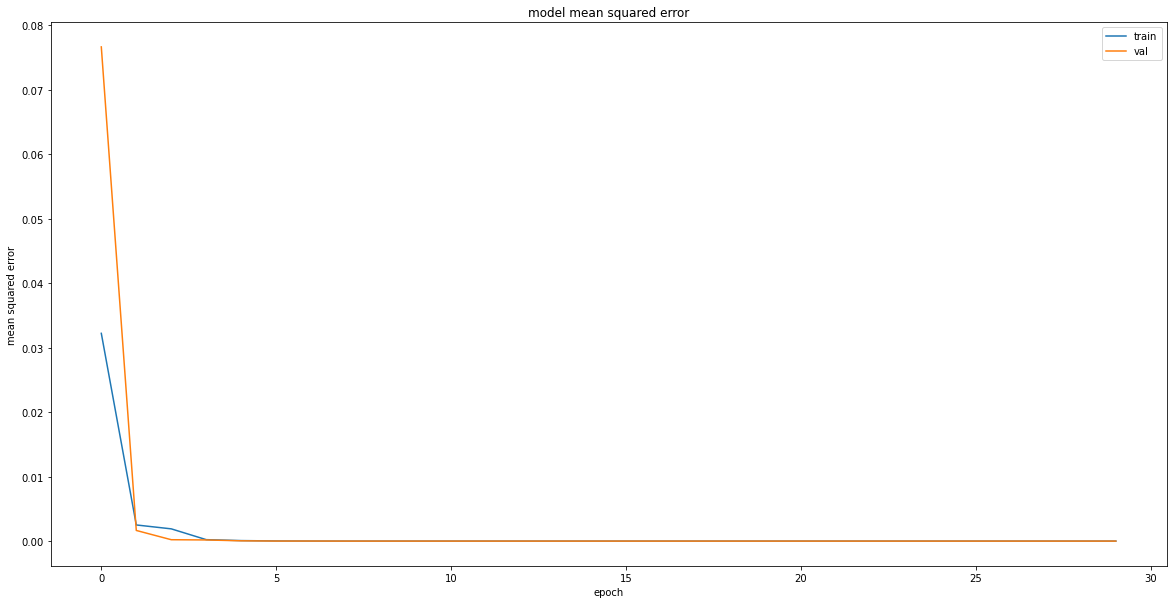

In [36]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

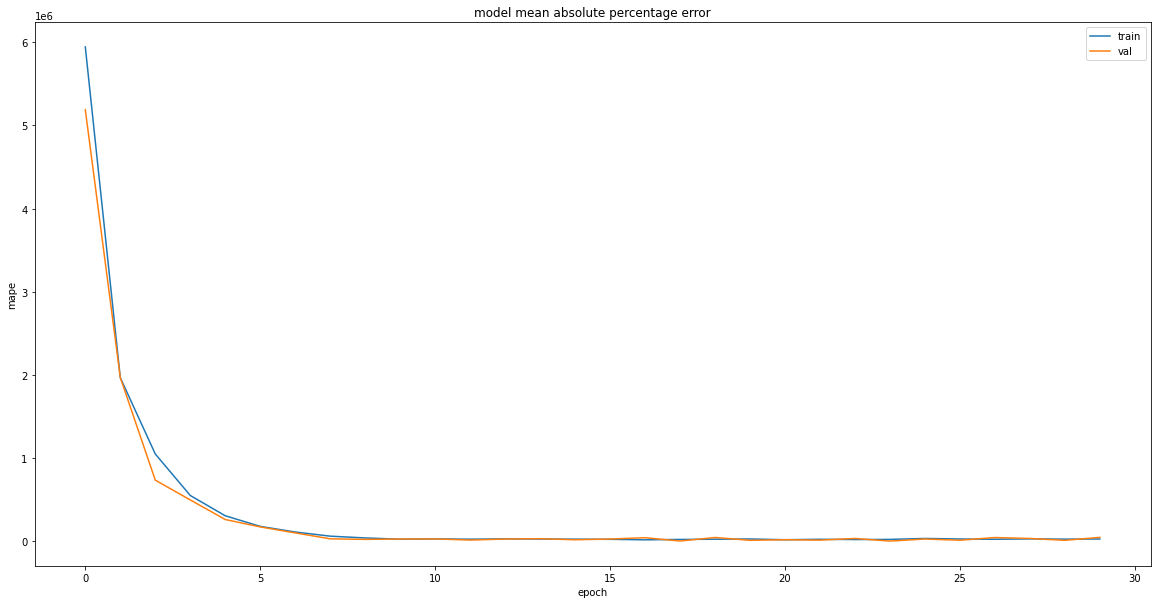

In [37]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [38]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
loss = model_6.evaluate(X_test, y_test)

  25/1080 [..............................] - ETA: 4s - loss: 1.1216e-04 - mse: 7.6492e-08 - mape: 3436.2256 - mae: 1.1216e-04 

2022-02-05 00:14:13.695203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1080/1080 [==============================] - 5s 5ms/step - loss: 7.1817e-05 - mse: 1.0326e-07 - mape: 3116.2524 - mae: 7.1817e-05


In [39]:
# percentage
y_pred = model_6.predict(X_test)

2022-02-05 00:14:18.931350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [40]:
type(y_pred)

numpy.ndarray

In [41]:
y_pred

array([[-3.9472619e-07],
       [-3.9472619e-07],
       [-2.9885477e-05],
       ...,
       [-2.4257924e-05],
       [ 7.7240235e-05],
       [ 3.7189989e-04]], dtype=float32)

In [42]:
y_test = np.array(y_test)

In [43]:
type(y_test)

numpy.ndarray

In [44]:
y_test

array([ 5.7333345e-05,  5.2818090e-05, -5.3348940e-05, ...,
       -7.7742166e-05,  1.4537053e-04,  5.3484901e-04], dtype=float32)

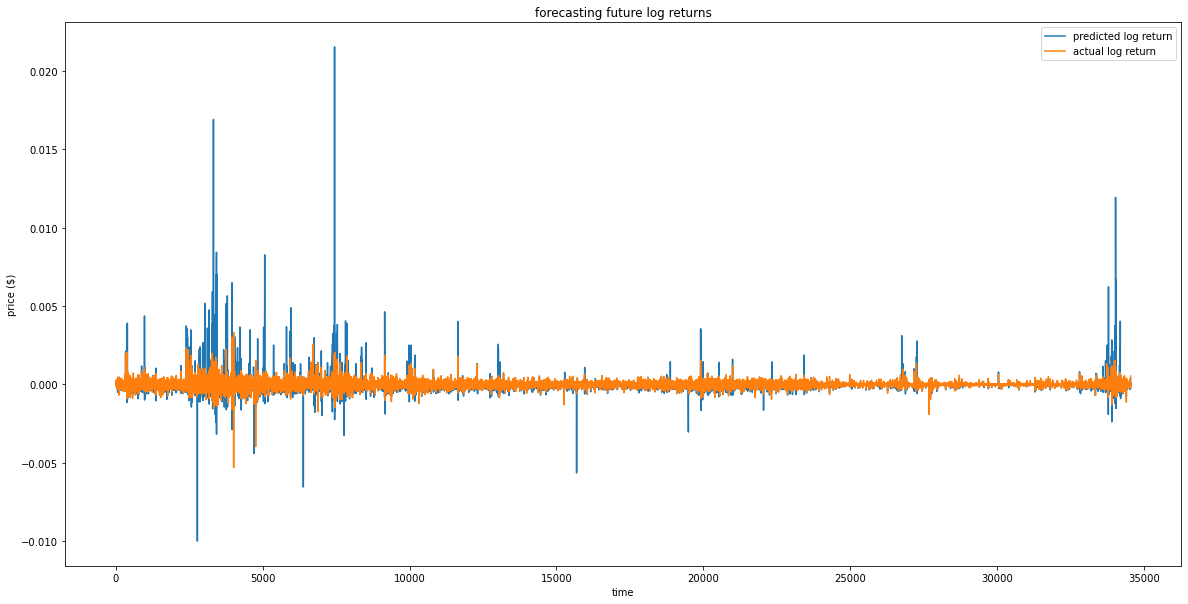

In [45]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

initial price should be price at X_test.timestamp-1

In [46]:
p_0 = X_test

In [47]:
# 1 step back as p_initial
p_0_time = X_test.index[0] - pd.Timedelta(X_test.index[0].freq)

In [48]:
p_0_test = df.loc[p_0_time]['Close']

### The price should be initial_price * exp(log_ret.cumsum())

In [49]:
tot_return_pct = y_pred.cumsum()
tot_return_pct

array([-3.9472619e-07, -7.8945237e-07, -3.0674932e-05, ...,
        1.9817758e-01,  1.9825482e-01,  1.9862673e-01], dtype=float32)

In [50]:
y_pred_prices = p_0_test*np.exp(y_pred.cumsum())

In [51]:
y_actual_prices = p_0_test*np.exp(y_test.cumsum())

In [52]:
len(y_pred_prices), len(y_actual_prices)

(34554, 34554)

In [53]:
y_pred_prices[:500]

array([37673.312, 37673.3  , 37672.17 , 37671.066, 37676.367, 37673.086,
       37673.7  , 37673.688, 37673.3  , 37672.38 , 37672.65 , 37673.03 ,
       37675.105, 37677.625, 37679.508, 37677.465, 37675.58 , 37671.156,
       37670.203, 37669.793, 37669.676, 37662.715, 37662.7  , 37663.016,
       37663.137, 37663.695, 37663.76 , 37663.746, 37663.73 , 37663.72 ,
       37664.56 , 37665.277, 37664.832, 37662.1  , 37668.457, 37677.2  ,
       37678.363, 37674.223, 37669.3  , 37665.715, 37664.137, 37663.21 ,
       37672.184, 37684.785, 37683.758, 37682.39 , 37684.887, 37690.78 ,
       37680.81 , 37686.52 , 37684.98 , 37689.18 , 37672.887, 37675.97 ,
       37680.707, 37685.754, 37690.7  , 37701.508, 37715.484, 37719.67 ,
       37718.906, 37722.348, 37703.574, 37708.9  , 37694.348, 37681.86 ,
       37678.45 , 37665.79 , 37670.74 , 37674.117, 37667.527, 37676.15 ,
       37686.504, 37692.887, 37698.637, 37706.336, 37719.72 , 37728.72 ,
       37708.82 , 37717.38 , 37719.38 , 37702.18 , 

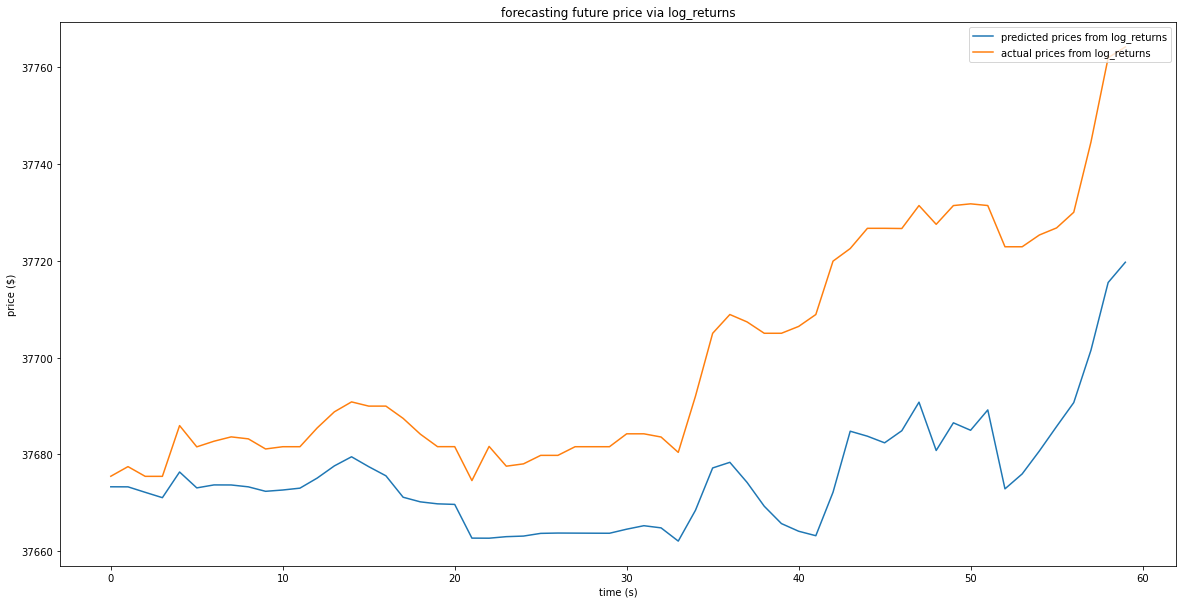

In [54]:
plt.plot(y_pred_prices[:60], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:60], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

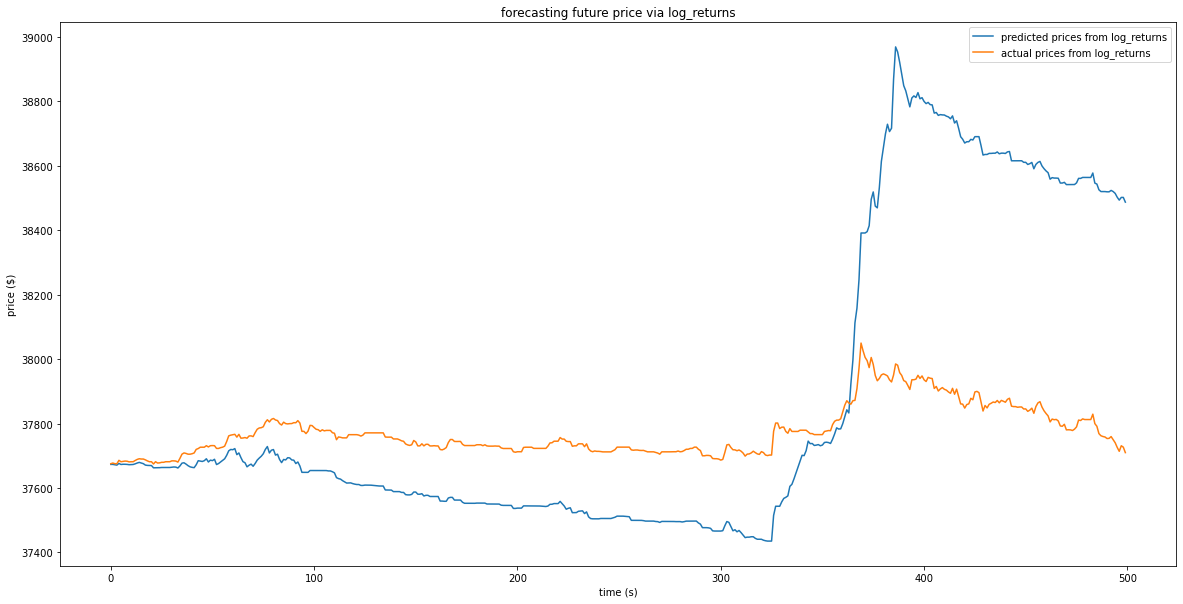

In [55]:
plt.plot(y_pred_prices[:500], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:500], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

### Observation: is okay for the first bit of data beyond train/val set, approx 50seconds, afterwards it flies!

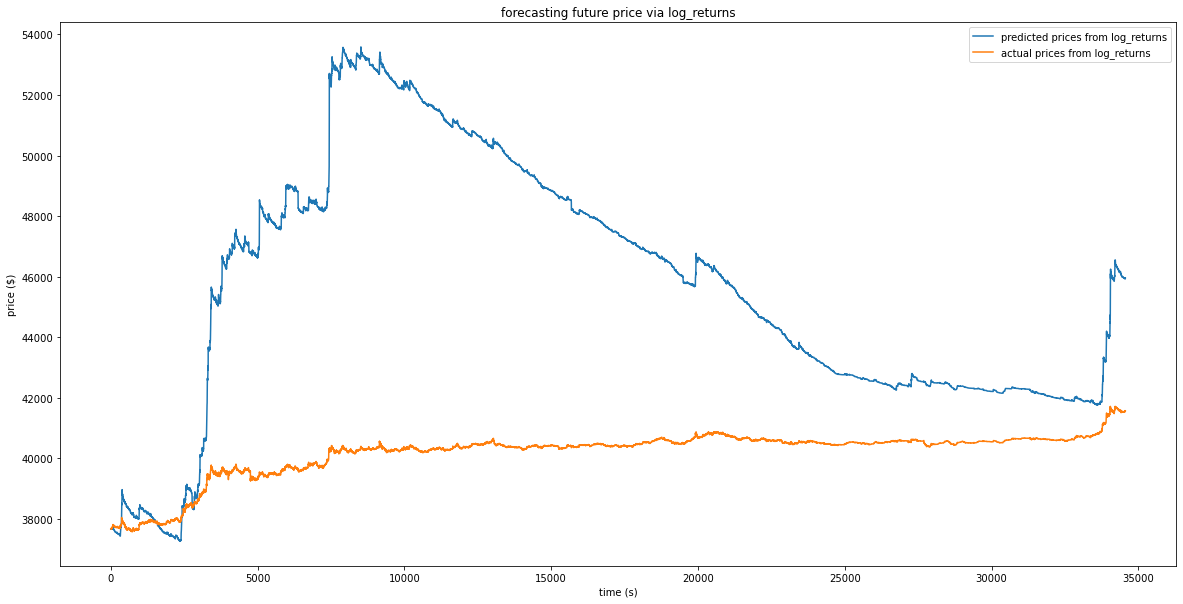

In [56]:
# for example, on the whole testing set
plt.plot(y_pred_prices, label="predicted prices from log_returns")
plt.plot(y_actual_prices, label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()